## Read data

In [1]:
import pandas as pd
import numpy as np

In [2]:
def read_data(L):
    """
    :type L: int(system size)
    :rtype train,test: pd.dataframe(with phases labeled)
    """
    train_filename='configuration'+str(L)+'.csv'
    test_filename='test'+str(L)+'.csv'
    columns=['temperature']+['Spin'+str(i) for i in xrange(1,L*L+1)]
    train=pd.read_csv('Ising_data/'+'L'+str(L)+'/'+train_filename,names=columns)
    test=pd.read_csv('Ising_data/'+'L'+str(L)+'/'+test_filename,names=columns)
    
    # decide critical temperature
    filename='Cv'+str(L)+'.csv'
    specific_heat=pd.read_csv('Ising_data/'+'L'+str(L)+'/'+filename,names=['temperature','Cv'])
    Tc=specific_heat['temperature'][np.argmax(specific_heat['Cv'])]
    
    # add phase column
    train['FM']=[int(T<=Tc) for T in train['temperature']]
    test['FM']=[int(T<=Tc) for T in test['temperature']]
    train['PM']=[int(T>Tc) for T in train['temperature']]
    test['PM']=[int(T>Tc) for T in test['temperature']]
    
    return train, test

In [3]:
train, test=read_data(30)

In [4]:
train.head()

,temperature,Spin1,Spin2,Spin3,Spin4,Spin5,Spin6,Spin7,Spin8,Spin9,...,Spin893,Spin894,Spin895,Spin896,Spin897,Spin898,Spin899,Spin900,FM,PM
0,1.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
1,1.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,1.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
4,1.0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


## Data processing

In [5]:
def data_process(train, test):
    """
    :type train,test: pd.dataframe(with phases labeled)
    :rtype trX, trY, teX, teY
    """
    # shuffle
    train=train.sample(frac=1).reset_index(drop=True)
    
    trX, trY = train.drop(['FM','PM','temperature'],axis=1), np.array(train[['FM','PM']])
    teX, teY = test.drop(['FM','PM','temperature'],axis=1), np.array(test[['FM','PM']])
    
    return trX, trY, teX, teY

In [6]:
trX, trY, teX, teY=data_process(train, test)

## Logistic Regression

In [7]:
import tensorflow as tf

In [9]:
def tf_logistic(trX, trY, teX, teY, batch_size=100, max_iter=20, eta=0.001):
    def init_weights(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.01))
    def init_bias(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.05))
    # The same function from linear regression
    def model(X, w, b):
        return tf.matmul(X, w)+b
    X = tf.placeholder("float", [None, trX.shape[1]]) # create symbolic variables
    Y = tf.placeholder("float", [None, trY.shape[1]])
    
    w = init_weights([trX.shape[1], trY.shape[1]])
    b = init_bias([trY.shape[1]])
    
    py_x = model(X, w, b)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
    train_op = tf.train.GradientDescentOptimizer(eta).minimize(cost) # construct optimizer
    
    # at predict time, evaluate the argmax of the logistic regression
    predict_op=tf.argmax(py_x,1)
    
    sess = tf.Session()
    # you need to initialize all variables
    sess.run(tf.global_variables_initializer())
    
    log_likelihood_all=[]
    
    for i in xrange(max_iter):
        for start, end in zip(range(0, len(trX), batch_size), \
                              range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
            log_likelihood_all.append(sess.run(cost,feed_dict={X: trX[start:end], \
                                                               Y: trY[start:end]}))
        
        print (i, np.mean(np.argmax(trY, axis=1) == \
                        sess.run(predict_op, feed_dict={X: trX, Y: trY}))),\
        (i, np.mean(np.argmax(teY, axis=1) ==
                        sess.run(predict_op, feed_dict={X: teX, Y: teY})))
        
    return log_likelihood_all

In [10]:
batch_size=100
log_likelihood_log=tf_logistic(trX, trY, teX, teY, batch_size=batch_size, eta=0.02)

(0, 0.98089499999999996) (0, 0.98807999999999996)
(1, 0.98145499999999997) (1, 0.98916000000000004)
(2, 0.98157499999999998) (2, 0.98936000000000002)
(3, 0.98162499999999997) (3, 0.98968)
(4, 0.98163) (4, 0.98968)
(5, 0.98165000000000002) (5, 0.98972000000000004)
(6, 0.98165000000000002) (6, 0.98972000000000004)
(7, 0.98165000000000002) (7, 0.98972000000000004)
(8, 0.98165000000000002) (8, 0.98972000000000004)
(9, 0.98165000000000002) (9, 0.98972000000000004)
(10, 0.98165000000000002) (10, 0.98972000000000004)
(11, 0.98165000000000002) (11, 0.98972000000000004)
(12, 0.98165000000000002) (12, 0.98972000000000004)
(13, 0.98165000000000002) (13, 0.98972000000000004)
(14, 0.98165000000000002) (14, 0.98972000000000004)
(15, 0.98165000000000002) (15, 0.98972000000000004)
(16, 0.98165000000000002) (16, 0.98972000000000004)
(17, 0.98165000000000002) (17, 0.98972000000000004)
(18, 0.98165000000000002) (18, 0.98972000000000004)
(19, 0.98165000000000002) (19, 0.98972000000000004)


## Feed-Forward Neural Network

In [11]:
def tf_fnn(trX, trY, teX, teY, lamb=0.05,hidden_units=100, batch_size=100, max_iter=20, eta=0.001):
    def init_weights(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.01))
    def init_bias(shape):
        return tf.Variable(tf.random_normal(shape,stddev=0.05))
    def layers(X, W, b):
        return tf.nn.sigmoid(tf.matmul(X, W)+b)
    
    X = tf.placeholder("float", [None, trX.shape[1]]) # create symbolic variables
    Y = tf.placeholder("float", [None, trY.shape[1]])
    
    w_1 = init_weights([trX.shape[1], hidden_units])
    b_1 = init_bias([hidden_units])
    w_2 = init_weights([hidden_units, trY.shape[1]])
    b_2 = init_bias([trY.shape[1]])
    O1 = layers(X, w_1, b_1)
    O2 = layers(O1, w_2, b_2)
    
    cross_entropy = tf.reduce_sum(-Y*tf.log(O2)-(1.0-Y)*tf.log(1.0-O2)\
                                  +lamb*(tf.nn.l2_loss(w_1)+tf.nn.l2_loss(w_2)))
    # train_op = tf.train.AdamOptimizer(eta).minimize(cross_entropy) # construct an optimizer
    train_op = tf.train.GradientDescentOptimizer(eta).minimize(cross_entropy)
    #predictions
    correct_prediction = tf.equal(tf.argmax(O2,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    sess = tf.Session()
    # you need to initialize all variables
    sess.run(tf.global_variables_initializer())
    
    log_likelihood_all=[]
    for i in range(max_iter):
        for start, end in zip(range(0, len(trX), batch_size),\
                              range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
            log_likelihood_all.append(1./float(batch_size)*sess.run(cross_entropy,\
                                               feed_dict={X: trX[start:end], Y: trY[start:end]}))
        train_accuracy = sess.run(accuracy,feed_dict={X: trX, Y: trY})
        test_accuracy = sess.run(accuracy,feed_dict={X: teX, Y: teY})
        print "step %d, training accuracy %g, test accuracy %g"%(i, train_accuracy, test_accuracy)
        
    return log_likelihood_all

In [12]:
batch_size=100

In [13]:
log_likelihood_fnn=tf_fnn(trX, trY, teX, teY, batch_size=batch_size, eta=0.005)

step 0, training accuracy 0.98139, test accuracy 0.98892
step 1, training accuracy 0.982355, test accuracy 0.99076
step 2, training accuracy 0.98289, test accuracy 0.99204
step 3, training accuracy 0.983105, test accuracy 0.99288
step 4, training accuracy 0.9832, test accuracy 0.99312
step 5, training accuracy 0.98332, test accuracy 0.99328
step 6, training accuracy 0.98344, test accuracy 0.99332
step 7, training accuracy 0.983455, test accuracy 0.9934
step 8, training accuracy 0.98347, test accuracy 0.99344
step 9, training accuracy 0.983495, test accuracy 0.99344
step 10, training accuracy 0.9835, test accuracy 0.99352
step 11, training accuracy 0.9835, test accuracy 0.99352
step 12, training accuracy 0.983495, test accuracy 0.99352
step 13, training accuracy 0.9835, test accuracy 0.99352
step 14, training accuracy 0.983495, test accuracy 0.99352
step 15, training accuracy 0.983505, test accuracy 0.99352
step 16, training accuracy 0.98351, test accuracy 0.99352
step 17, training accu

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

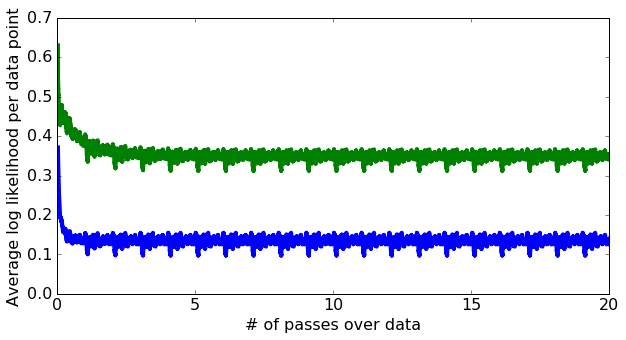

In [18]:
make_plot(log_likelihood_log, trX.shape[0], batch_size, 100, label='logistic')
make_plot(log_likelihood_fnn, trX.shape[0], batch_size, 100, label='fnn')

In [19]:
log_likelihood_fnn={}
for hidden_units in [10,50,100,200,400]:
    log_likelihood_fnn[hidden_units]= \
    tf_fnn(trX, trY, teX, teY, hidden_units=hidden_units, batch_size=batch_size, eta=0.005)

step 0, training accuracy 0.98225, test accuracy 0.9904
step 1, training accuracy 0.98278, test accuracy 0.99188
step 2, training accuracy 0.98294, test accuracy 0.99236
step 3, training accuracy 0.983, test accuracy 0.99248
step 4, training accuracy 0.983005, test accuracy 0.99248
step 5, training accuracy 0.98301, test accuracy 0.99252
step 6, training accuracy 0.983015, test accuracy 0.99252
step 7, training accuracy 0.983015, test accuracy 0.99252
step 8, training accuracy 0.983015, test accuracy 0.99252
step 9, training accuracy 0.983015, test accuracy 0.99252
step 10, training accuracy 0.983015, test accuracy 0.99252
step 11, training accuracy 0.983015, test accuracy 0.99252
step 12, training accuracy 0.983015, test accuracy 0.99252
step 13, training accuracy 0.983015, test accuracy 0.99252
step 14, training accuracy 0.983015, test accuracy 0.99252
step 15, training accuracy 0.983015, test accuracy 0.99252
step 16, training accuracy 0.983015, test accuracy 0.99252
step 17, traini

KeyboardInterrupt: 

In [32]:
hidden_units=400
log_likelihood_fnn[hidden_units]= \
    tf_fnn(trX, trY, teX, teY, hidden_units=hidden_units, batch_size=batch_size, eta=0.002)

step 0, training accuracy 0.981415, test accuracy 0.98892
step 1, training accuracy 0.981505, test accuracy 0.98912
step 2, training accuracy 0.98163, test accuracy 0.98932
step 3, training accuracy 0.981785, test accuracy 0.98952
step 4, training accuracy 0.98188, test accuracy 0.98964
step 5, training accuracy 0.98198, test accuracy 0.98988
step 6, training accuracy 0.982095, test accuracy 0.99024
step 7, training accuracy 0.98221, test accuracy 0.99032
step 8, training accuracy 0.982325, test accuracy 0.9908
step 9, training accuracy 0.98244, test accuracy 0.99108
step 10, training accuracy 0.982545, test accuracy 0.99144
step 11, training accuracy 0.982695, test accuracy 0.99172
step 12, training accuracy 0.982835, test accuracy 0.99192
step 13, training accuracy 0.98294, test accuracy 0.99216
step 14, training accuracy 0.98302, test accuracy 0.99244
step 15, training accuracy 0.98306, test accuracy 0.99264
step 16, training accuracy 0.983085, test accuracy 0.99284
step 17, trainin

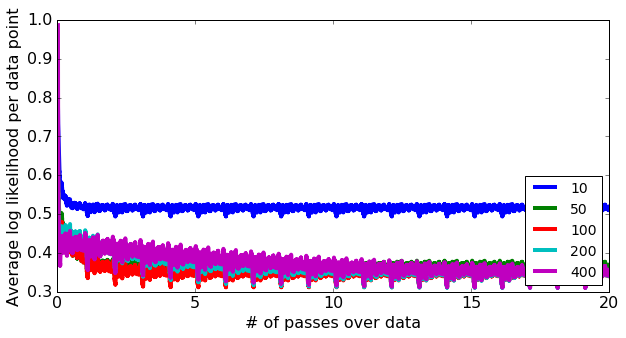

In [39]:
for hidden_units in sorted(log_likelihood_fnn.keys()):
    make_plot(log_likelihood_fnn[hidden_units], trX.shape[0], batch_size,100,\
              label='%i'%hidden_units)

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
clf = MLPClassifier(solver='lbfgs', alpha=0.05, activation='logistic',
...                     hidden_layer_sizes=(hidden_units,))

In [30]:
hidden_units

50

In [29]:
clf.fit(trX,trY)

KeyboardInterrupt: 

In [ ]:
y_pred=clf.predict(teX)

In [ ]:
correct_prediction = np.argmax(y_pred,1)==np.argmax(teY,1)

In [ ]:
np.mean(correct_prediction)

In [ ]:
trX.head()

In [ ]:
log_likelihood_all